# Method 7 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

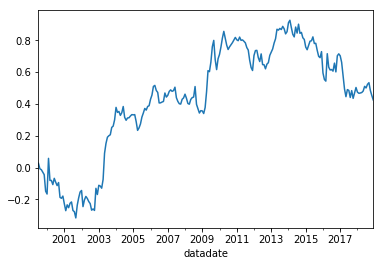

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.148315
2000-12-31   -0.036335
2001-12-31    0.031303
2002-12-31   -0.018521
2003-12-31    0.565105
2004-12-31    0.025269
2005-12-31    0.041779
2006-12-31    0.039090
2007-12-31   -0.003610
2008-12-31   -0.055585
2009-12-31    0.240082
2010-12-31    0.079774
2011-12-31   -0.114417
2012-12-31    0.059125
2013-12-31    0.087244
2014-12-31   -0.026204
2015-12-31   -0.042428
2016-12-31   -0.008114
2017-12-31   -0.123306
2018-12-31   -0.052225
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     44.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.94e-28
Time:                        21:47:12   Log-Likelihood:                 481.93
No. Observations:                 234   AIC:                            -953.9
Df Residuals:                     229   BIC:                            -936.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.134      0.258      -0.002       0.007
mktrf         -0.0611      0.058     -1.051      0.294      -0.176       0.053
me             0.5083      0.068      7.512      0.000       0.375       0.642
ia             0.2061      0.103      2.004      0.046       0.003       0.409
roe           -0.6151      0.088     -6.988      0.000      -0.789      -0.442
==============================================================================
Omnibus:                       35.095   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.426
Skew:                          -0.008   Prob(JB):                     2.57e-60
Kurtosis:                       8.305   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     25.85
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-17
Time:                        21:47:12   Log-Likelihood:                 481.93
No. Observations:                 234   AIC:                            -953.9
Df Residuals:                     229   BIC:                            -936.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.895      0.371      -0.003       0.008
mktrf         -0.0611      0.052     -1.181      0.238      -0.163       0.040
me             0.5083      0.106      4.792      0.000       0.300       0.716
ia             0.2061      0.151      1.368      0.171      -0.089       0.501
roe           -0.6151      0.182     -3.383      0.001      -0.971      -0.259
==============================================================================
Omnibus:                       35.095   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.426
Skew:                          -0.008   Prob(JB):                     2.57e-60
Kurtosis:                       8.305   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     40.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-25
Time:                        21:47:12   Log-Likelihood:                 481.93
No. Observations:                 234   AIC:                            -953.9
Df Residuals:                     229   BIC:                            -936.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.804      0.421      -0.003       0.008
mktrf         -0.0611      0.048     -1.269      0.204      -0.156       0.033
me             0.5083      0.107      4.753      0.000       0.299       0.718
ia             0.2061      0.134      1.535      0.125      -0.057       0.469
roe           -0.6151      0.207     -2.966      0.003      -1.022      -0.209
==============================================================================
Omnibus:                       35.095   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.426
Skew:                          -0.008   Prob(JB):                     2.57e-60
Kurtosis:                       8.305   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     39.41
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.32e-29
Time:                        21:47:12   Log-Likelihood:                 487.15
No. Observations:                 234   AIC:                            -962.3
Df Residuals:                     228   BIC:                            -941.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.260      0.209      -0.002       0.007
mktrf         -0.0176      0.057     -0.308      0.758      -0.130       0.095
smb            0.4313      0.075      5.723      0.000       0.283       0.580
hml            0.0793      0.089      0.893      0.373      -0.096       0.254
rmw           -0.6932      0.100     -6.899      0.000      -0.891      -0.495
cma            0.3357      0.128      2.628      0.009       0.084       0.587
==============================================================================
Omnibus:                       35.076   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.627
Skew:                          -0.252   Prob(JB):                     3.73e-50
Kurtosis:                       7.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     34.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.25e-26
Time:                        21:47:12   Log-Likelihood:                 487.15
No. Observations:                 234   AIC:                            -962.3
Df Residuals:                     228   BIC:                            -941.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.151      0.250      -0.002       0.007
mktrf         -0.0176      0.053     -0.331      0.741      -0.122       0.087
smb            0.4313      0.056      7.729      0.000       0.322       0.541
hml            0.0793      0.120      0.661      0.508      -0.156       0.314
rmw           -0.6932      0.141     -4.920      0.000      -0.969      -0.417
cma            0.3357      0.194      1.733      0.083      -0.044       0.715
==============================================================================
Omnibus:                       35.076   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.627
Skew:                          -0.252   Prob(JB):                     3.73e-50
Kurtosis:                       7.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     63.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.45e-41
Time:                        21:47:13   Log-Likelihood:                 487.15
No. Observations:                 234   AIC:                            -962.3
Df Residuals:                     228   BIC:                            -941.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.069      0.285      -0.002       0.008
mktrf         -0.0176      0.056     -0.313      0.754      -0.128       0.093
smb            0.4313      0.046      9.422      0.000       0.342       0.521
hml            0.0793      0.106      0.746      0.456      -0.129       0.288
rmw           -0.6932      0.157     -4.416      0.000      -1.001      -0.386
cma            0.3357      0.158      2.123      0.034       0.026       0.646
==============================================================================
Omnibus:                       35.076   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.627
Skew:                          -0.252   Prob(JB):                     3.73e-50
Kurtosis:                       7.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     35.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.63e-23
Time:                        21:47:13   Log-Likelihood:                 470.70
No. Observations:                 234   AIC:                            -931.4
Df Residuals:                     229   BIC:                            -914.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.360      0.719      -0.004       0.005
mktrf          0.0374      0.056      0.665      0.506      -0.073       0.148
smb            0.7422      0.070     10.582      0.000       0.604       0.880
hml            0.0782      0.070      1.123      0.263      -0.059       0.216
umd           -0.1733      0.046     -3.791      0.000      -0.263      -0.083
==============================================================================
Omnibus:                       39.843   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.651
Skew:                           0.210   Prob(JB):                     2.38e-75
Kurtosis:                       8.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     17.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-12
Time:                        21:47:13   Log-Likelihood:                 470.70
No. Observations:                 234   AIC:                            -931.4
Df Residuals:                     229   BIC:                            -914.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.341      0.733      -0.004       0.005
mktrf          0.0374      0.052      0.715      0.475      -0.065       0.140
smb            0.7422      0.114      6.532      0.000       0.520       0.965
hml            0.0782      0.088      0.892      0.372      -0.094       0.250
umd           -0.1733      0.099     -1.759      0.079      -0.366       0.020
==============================================================================
Omnibus:                       39.843   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.651
Skew:                           0.210   Prob(JB):                     2.38e-75
Kurtosis:                       8.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     22.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.65e-16
Time:                        21:47:13   Log-Likelihood:                 470.70
No. Observations:                 234   AIC:                            -931.4
Df Residuals:                     229   BIC:                            -914.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.316      0.752      -0.004       0.006
mktrf          0.0374      0.045      0.825      0.410      -0.051       0.126
smb            0.7422      0.090      8.251      0.000       0.566       0.919
hml            0.0782      0.087      0.895      0.371      -0.093       0.250
umd           -0.1733      0.099     -1.758      0.079      -0.367       0.020
==============================================================================
Omnibus:                       39.843   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.651
Skew:                           0.210   Prob(JB):                     2.38e-75
Kurtosis:                       8.922   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     21.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.48e-13
Time:                        21:47:13   Log-Likelihood:                 220.27
No. Observations:                 120   AIC:                            -430.5
Df Residuals:                     115   BIC:                            -416.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.004      0.895      0.373      -0.004       0.011
mktrf         -0.0133      0.102     -0.131      0.896      -0.215       0.188
me             0.5544      0.100      5.523      0.000       0.356       0.753
ia             0.2098      0.157      1.335      0.185      -0.102       0.521
roe           -0.5361      0.139     -3.853      0.000      -0.812      -0.261
==============================================================================
Omnibus:                       14.876   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.027
Skew:                          -0.086   Prob(JB):                     1.85e-12
Kurtosis:                       6.283   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     17.09
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.01e-11
Time:                        21:47:13   Log-Likelihood:                 220.27
No. Observations:                 120   AIC:                            -430.5
Df Residuals:                     115   BIC:                            -416.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.668      0.504      -0.007       0.013
mktrf         -0.0133      0.079     -0.169      0.866      -0.167       0.141
me             0.5544      0.143      3.869      0.000       0.274       0.835
ia             0.2098      0.211      0.996      0.319      -0.203       0.623
roe           -0.5361      0.253     -2.116      0.034      -1.033      -0.040
==============================================================================
Omnibus:                       14.876   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.027
Skew:                          -0.086   Prob(JB):                     1.85e-12
Kurtosis:                       6.283   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     28.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-16
Time:                        21:47:13   Log-Likelihood:                 220.27
No. Observations:                 120   AIC:                            -430.5
Df Residuals:                     115   BIC:                            -416.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.006      0.590      0.555      -0.008       0.015
mktrf         -0.0133      0.073     -0.182      0.856      -0.157       0.130
me             0.5544      0.150      3.700      0.000       0.261       0.848
ia             0.2098      0.193      1.088      0.276      -0.168       0.588
roe           -0.5361      0.292     -1.837      0.066      -1.108       0.036
==============================================================================
Omnibus:                       14.876   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.027
Skew:                          -0.086   Prob(JB):                     1.85e-12
Kurtosis:                       6.283   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     20.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.32e-15
Time:                        21:47:13   Log-Likelihood:                 226.07
No. Observations:                 120   AIC:                            -440.1
Df Residuals:                     114   BIC:                            -423.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.389      0.168      -0.002       0.012
mktrf          0.0100      0.103      0.098      0.922      -0.193       0.213
smb            0.4262      0.116      3.670      0.000       0.196       0.656
hml            0.0543      0.142      0.381      0.704      -0.228       0.336
rmw           -0.7018      0.168     -4.181      0.000      -1.034      -0.369
cma            0.4032      0.184      2.193      0.030       0.039       0.767
==============================================================================
Omnibus:                       20.436   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.874
Skew:                          -0.496   Prob(JB):                     8.18e-15
Kurtosis:                       6.463   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     27.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.50e-18
Time:                        21:47:13   Log-Likelihood:                 226.07
No. Observations:                 120   AIC:                            -440.1
Df Residuals:                     114   BIC:                            -423.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.188      0.235      -0.003       0.014
mktrf          0.0100      0.099      0.101      0.919      -0.183       0.203
smb            0.4262      0.081      5.261      0.000       0.267       0.585
hml            0.0543      0.191      0.284      0.776      -0.321       0.429
rmw           -0.7018      0.217     -3.238      0.001      -1.127      -0.277
cma            0.4032      0.235      1.717      0.086      -0.057       0.863
==============================================================================
Omnibus:                       20.436   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.874
Skew:                          -0.496   Prob(JB):                     8.18e-15
Kurtosis:                       6.463   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     55.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.35e-29
Time:                        21:47:13   Log-Likelihood:                 226.07
No. Observations:                 120   AIC:                            -440.1
Df Residuals:                     114   BIC:                            -423.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.005      1.090      0.276      -0.004       0.014
mktrf          0.0100      0.103      0.097      0.922      -0.191       0.211
smb            0.4262      0.073      5.841      0.000       0.283       0.569
hml            0.0543      0.184      0.295      0.768      -0.306       0.415
rmw           -0.7018      0.241     -2.906      0.004      -1.175      -0.229
cma            0.4032      0.179      2.250      0.024       0.052       0.754
==============================================================================
Omnibus:                       20.436   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.874
Skew:                          -0.496   Prob(JB):                     8.18e-15
Kurtosis:                       6.463   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     19.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-12
Time:                        21:47:13   Log-Likelihood:                 218.61
No. Observations:                 120   AIC:                            -427.2
Df Residuals:                     115   BIC:                            -413.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.626      0.533      -0.005       0.010
mktrf          0.0658      0.091      0.724      0.470      -0.114       0.246
smb            0.7839      0.103      7.584      0.000       0.579       0.989
hml            0.0459      0.104      0.444      0.658      -0.159       0.251
umd           -0.1747      0.064     -2.737      0.007      -0.301      -0.048
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.732
Skew:                          -0.100   Prob(JB):                     7.30e-21
Kurtosis:                       7.302   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     15.65
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.99e-10
Time:                        21:47:13   Log-Likelihood:                 218.61
No. Observations:                 120   AIC:                            -427.2
Df Residuals:                     115   BIC:                            -413.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.585      0.558      -0.006       0.010
mktrf          0.0658      0.079      0.834      0.404      -0.089       0.220
smb            0.7839      0.141      5.578      0.000       0.508       1.059
hml            0.0459      0.124      0.371      0.711      -0.197       0.289
umd           -0.1747      0.122     -1.434      0.152      -0.414       0.064
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.732
Skew:                          -0.100   Prob(JB):                     7.30e-21
Kurtosis:                       7.302   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     28.00
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.08e-16
Time:                        21:47:13   Log-Likelihood:                 218.61
No. Observations:                 120   AIC:                            -427.2
Df Residuals:                     115   BIC:                            -413.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.524      0.600      -0.006       0.011
mktrf          0.0658      0.066      0.993      0.321      -0.064       0.196
smb            0.7839      0.116      6.776      0.000       0.557       1.011
hml            0.0459      0.138      0.332      0.740      -0.225       0.317
umd           -0.1747      0.116     -1.512      0.131      -0.401       0.052
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.732
Skew:                          -0.100   Prob(JB):                     7.30e-21
Kurtosis:                       7.302   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     28.70
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.71e-16
Time:                        21:47:13   Log-Likelihood:                 290.59
No. Observations:                 114   AIC:                            -571.2
Df Residuals:                     109   BIC:                            -557.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.612      0.542      -0.003       0.005
mktrf         -0.0594      0.057     -1.045      0.298      -0.172       0.053
me             0.3539      0.088      4.031      0.000       0.180       0.528
ia             0.1543      0.122      1.267      0.208      -0.087       0.396
roe           -0.7971      0.107     -7.449      0.000      -1.009      -0.585
==============================================================================
Omnibus:                        1.397   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                1.011
Skew:                           0.218   Prob(JB):                        0.603
Kurtosis:                       3.152   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     28.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.66e-16
Time:                        21:47:13   Log-Likelihood:                 290.59
No. Observations:                 114   AIC:                            -571.2
Df Residuals:                     109   BIC:                            -557.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.090      0.276      -0.001       0.003
mktrf         -0.0594      0.044     -1.338      0.181      -0.146       0.028
me             0.3539      0.053      6.691      0.000       0.250       0.458
ia             0.1543      0.161      0.957      0.339      -0.162       0.470
roe           -0.7971      0.139     -5.754      0.000      -1.069      -0.526
==============================================================================
Omnibus:                        1.397   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                1.011
Skew:                           0.218   Prob(JB):                        0.603
Kurtosis:                       3.152   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     34.94
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.34e-19
Time:                        21:47:13   Log-Likelihood:                 290.59
No. Observations:                 114   AIC:                            -571.2
Df Residuals:                     109   BIC:                            -557.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.140      0.254      -0.001       0.003
mktrf         -0.0594      0.043     -1.367      0.172      -0.145       0.026
me             0.3539      0.045      7.871      0.000       0.266       0.442
ia             0.1543      0.183      0.844      0.399      -0.204       0.513
roe           -0.7971      0.118     -6.740      0.000      -1.029      -0.565
==============================================================================
Omnibus:                        1.397   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                1.011
Skew:                           0.218   Prob(JB):                        0.603
Kurtosis:                       3.152   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     16.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.98e-12
Time:                        21:47:13   Log-Likelihood:                 281.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     108   BIC:                            -534.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.841e-05      0.002      0.042      0.967      -0.004       0.004
mktrf         -0.0125      0.059     -0.212      0.832      -0.130       0.104
smb            0.3975      0.096      4.147      0.000       0.208       0.587
hml            0.2001      0.122      1.637      0.105      -0.042       0.442
rmw           -0.5901      0.150     -3.943      0.000      -0.887      -0.293
cma            0.0978      0.190      0.515      0.608      -0.279       0.474
==============================================================================
Omnibus:                        9.121   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.596
Skew:                           0.175   Prob(JB):                     9.16e-05
Kurtosis:                       4.947   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     12.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.33e-09
Time:                        21:47:13   Log-Likelihood:                 281.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     108   BIC:                            -534.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.841e-05      0.001      0.060      0.952      -0.003       0.003
mktrf         -0.0125      0.059     -0.213      0.831      -0.128       0.102
smb            0.3975      0.070      5.688      0.000       0.260       0.534
hml            0.2001      0.091      2.194      0.028       0.021       0.379
rmw           -0.5901      0.198     -2.973      0.003      -0.979      -0.201
cma            0.0978      0.202      0.485      0.628      -0.298       0.494
==============================================================================
Omnibus:                        9.121   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.596
Skew:                           0.175   Prob(JB):                     9.16e-05
Kurtosis:                       4.947   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     14.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.35e-11
Time:                        21:47:13   Log-Likelihood:                 281.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     108   BIC:                            -534.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.841e-05      0.001      0.059      0.953      -0.003       0.003
mktrf         -0.0125      0.064     -0.195      0.846      -0.139       0.113
smb            0.3975      0.069      5.769      0.000       0.262       0.532
hml            0.2001      0.099      2.016      0.044       0.006       0.395
rmw           -0.5901      0.204     -2.891      0.004      -0.990      -0.190
cma            0.0978      0.237      0.413      0.680      -0.367       0.563
==============================================================================
Omnibus:                        9.121   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.596
Skew:                           0.175   Prob(JB):                     9.16e-05
Kurtosis:                       4.947   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     14.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.36e-09
Time:                        21:47:13   Log-Likelihood:                 274.07
No. Observations:                 114   AIC:                            -538.1
Df Residuals:                     109   BIC:                            -524.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.266      0.791      -0.005       0.004
mktrf          0.0176      0.062      0.282      0.778      -0.106       0.141
smb            0.5190      0.097      5.344      0.000       0.326       0.711
hml            0.2952      0.100      2.951      0.004       0.097       0.493
umd           -0.1125      0.075     -1.491      0.139      -0.262       0.037
==============================================================================
Omnibus:                       12.590   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.128
Skew:                           0.239   Prob(JB):                     6.40e-08
Kurtosis:                       5.597   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     13.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.51e-09
Time:                        21:47:13   Log-Likelihood:                 274.07
No. Observations:                 114   AIC:                            -538.1
Df Residuals:                     109   BIC:                            -524.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.372      0.710      -0.004       0.003
mktrf          0.0176      0.054      0.323      0.747      -0.089       0.124
smb            0.5190      0.075      6.896      0.000       0.371       0.667
hml            0.2952      0.115      2.572      0.010       0.070       0.520
umd           -0.1125      0.067     -1.684      0.092      -0.243       0.018
==============================================================================
Omnibus:                       12.590   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.128
Skew:                           0.239   Prob(JB):                     6.40e-08
Kurtosis:                       5.597   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     22.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.67e-14
Time:                        21:47:13   Log-Likelihood:                 274.07
No. Observations:                 114   AIC:                            -538.1
Df Residuals:                     109   BIC:                            -524.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.366      0.714      -0.004       0.003
mktrf          0.0176      0.056      0.317      0.751      -0.091       0.126
smb            0.5190      0.060      8.685      0.000       0.402       0.636
hml            0.2952      0.111      2.661      0.008       0.078       0.513
umd           -0.1125      0.054     -2.080      0.038      -0.218      -0.007
==============================================================================
Omnibus:                       12.590   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.128
Skew:                           0.239   Prob(JB):                     6.40e-08
Kurtosis:                       5.597   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""